## Bayes module

### Optimisation of Catoni's bound

Given a score $S$, a parametric family of distributions $(\nu_{\theta})_{\theta \in \Theta}$ and a prior distribution $\pi$, we consider the minimisation problem

$$\hat{\theta} = \arg\inf \nu_{\theta}[S] + \lambda * KL(\nu_{\theta}, \pi).$$

The function pacbayes_minimize is designed to tackle such problems in the setting where $\pi =  \nu_{\theta_0}$. This is in order to benefit from potential closed form expressions when computing the Kullback-Leibler divergence and its derivative.

# SurPAC-CE algorithm

SurPAC-CE (Surrogate PAC-Bayes for Catoni's bound minimisation on Exponential family) algorithm relies on surpbayes.proba submodule. The current form of the algorithm requires the family of distributions of interest to be an exponential family (classes "surpbayes.proba.PreExpFamily" and "surpbayes.proba.ExponentialFamily"). A slightly modified version is used in the case of Gaussian distributions (inherited from "surpbayes.proba.PreExpFamily").

To demonstrate SurPAC-CE, a one dimensional problem is considered. However, SurPAC-CE can be used for problems of any dimension, although for large dimensions (> 100), some inner mechanisms (the weighing process) should be assessed and potentially modified. First, we define a tailor-made error function. For maximum efficiency, this function is vectorized.

Note that for demonstration reasons, the hyperparameters of the algorithm are chosen as really conservative. This implies that the algorithm takes more time to converge than it could, and evaluates the score many more time than is really necessary. The resulting graphs are much smoother and the training mechanism better explained.

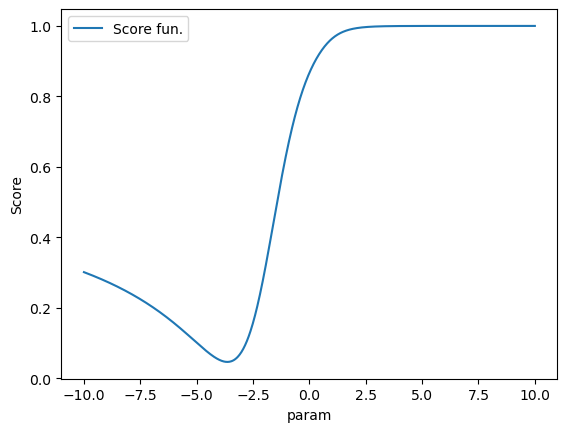

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from surpbayes.bayes import pacbayes_minimize

from surpbayes.proba import GaussianMap, TensorizedGaussianMap, BlockDiagGaussMap

xs = np.linspace(-10, 10, 10**3)

def fun(x):
    return (np.tan(np.sqrt(1 + np.arctan(x - 1.57) ** 2) - 1.0) - 3) ** 2


def gun(x):
    return (np.tanh(x) + 1) / 2


def S(x):
    return (2 - fun(0.7 * (x - 0.4))) * gun(-0.2 - 0.7 * (x - 0.4)) + 3


def score(x):
    return (S(x[:, 0]+2) +.25) /3.25

plt.plot(xs, score(xs[:, np.newaxis]), label="Score fun.")
plt.xlabel("param")
plt.ylabel("Score")
plt.legend()
plt.show()

Calls to SurPAC-CE can be performed using the pacbayes_minimize function from bayes module as follow

In [2]:
from surpbayes.bayes import pacbayes_minimize
from surpbayes.proba import GaussianMap

from time import time

gmap = GaussianMap(1)

tic = time()
opt_res_new = pacbayes_minimize(
    score,
    gmap,
    # As not specified, prior used is the reference of gmap (i.e. standard Gaussian)
    # As not specified, initial guess for posterior is the prior 
    optimizer="SurPAC-CE",
    temperature=0.015,  
    # Hyperparameters
    per_step=160, # score evaluations per step
    chain_length=51,
    n_estim_weights=10**4,
    # regularisation parameters
    dampen=0.7,
    kl_max=0.1,
    # dichotomy hyperparams for regularisation (can be omitted)
    m_max=20,
    xtol=10**-4,
    kltol=10**-4,
    # function call information
    parallel=False,
    vectorized=True,
    # printing params
    print_rec=5,
)
tac = time()
print("Time elapsed:", tac - tic)

Starting Bayesian calibration (Score Approximation routine, Gaussian variant)
Score at step 5/51: 0.40149063829707826 (KL: 2.08185618029239, score:0.37026279559269243)
Score at step 10/51: 0.15720770298130196 (KL: 6.203058757509381, score:0.06416182161866125)


/Users/apicard/Documents/Suez/Git/neurips_surroogate_pac_bayes/surpbayes/src/surpbayes/optim/dichoto.py:141: UserWarning: The required precision in y could not be achieved
  warnings.warn("The required precision in y could not be achieved")


Score at step 15/51: 0.1541736863978194 (KL: 6.3004094230743455, score:0.05966754505170422)
End score:  0.15448017569566874 (KL: 6.300009729035077, score:0.05998002976014259)
Time elapsed: 0.47199106216430664


The algorithm converged in less than 20 steps.
The evolution of the approximation of the posterior can be easily represented in this 1D setting by plotting the densities.

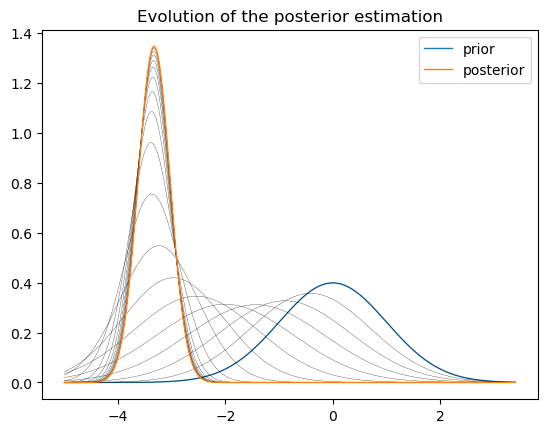

In [3]:
xs = np.linspace(-5.0, 3.4, 2000)


def repr_gauss(param):
    distr = gmap(param)
    return xs, distr.dens(xs[:, np.newaxis])


plt.plot(*repr_gauss(opt_res_new.hist_param[0]), linewidth=1.0, label="prior")
for i, param in enumerate(opt_res_new.hist_param[:]):
    if i % 1 == 0:

        xs, ys = repr_gauss(param)
        plt.plot(xs, ys, color="black", linewidth=0.2)

plt.plot(*repr_gauss(opt_res_new.hist_param[-1]), linewidth=1.0, label="posterior")
plt.title("Evolution of the posterior estimation")
plt.legend()
plt.show()

Let us see what happens in detail during this training phase.

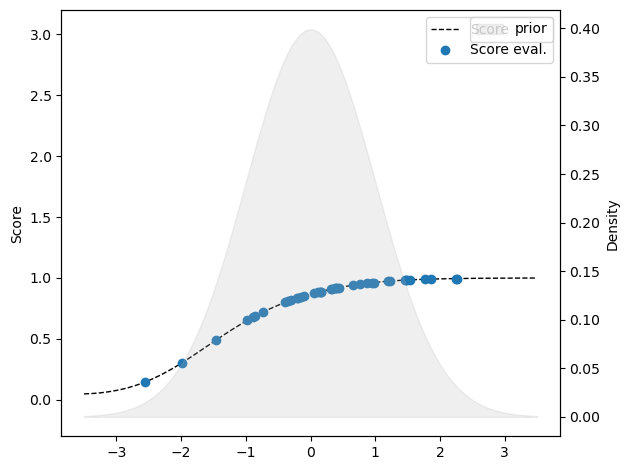

In [4]:
from surpbayes.bayes.score_approx.weighing import get_weights_mc
from surpbayes.bayes.score_approx.score_approx_solver import exp_approximation
from scipy.stats import norm

np.random.seed(0)

temp = 0.02
dampen = 0.975
n_sample = 40

xs = np.linspace(-3.5, 3.5, 1000)

prior_param = gmap.ref_param
prior = gmap(prior_param)
prior_norm = norm(loc=prior.means[0], scale=np.sqrt(prior.cov[0, 0]))

sample = prior(n_sample)
score_sample = score(sample)

# Plotting
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.set_ylabel("Density")
ax1.set_ylabel("Score")

ax2.fill_between(xs, prior_norm.pdf(xs), color="0.7", alpha=0.2, label="prior")
ax1.plot(
    xs, score(xs[:, np.newaxis]), "--", linewidth=1.0, color="black", label="Score"
)

ax1.plot(sample, score_sample, "o", markersize=6.0, label="Score eval.")
ax1.set_ylim(-0.3, 3.2)
ax1.legend()
ax2.legend()

fig.tight_layout()
plt.show()

Parameters are drawn from the current posterior approximation. The scores of these parameters are evaluated and added to the stack of parameters evaluated so far.

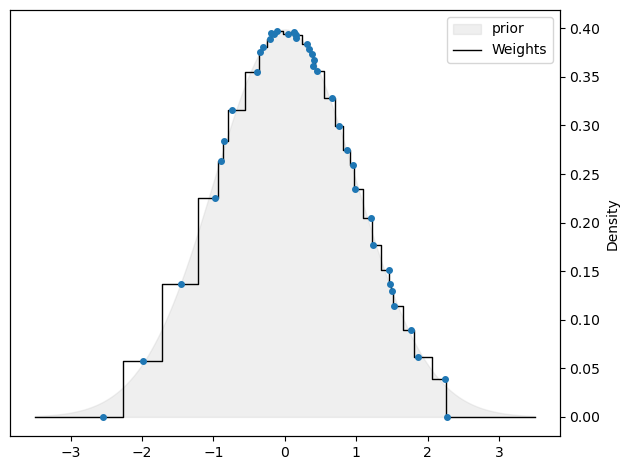

In [5]:
# # Infer estimation of score
weights = get_weights_mc(prior, sample, n_sample_estim=10**5)
m_score = np.sum(score_sample * weights)

# For plottinf
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.set_ylabel("Density")
# ax1.set_ylabel("Score")


ax2.fill_between(xs, prior_norm.pdf(xs), color="0.7", alpha=0.2, label="prior")


loc_sample = sample.copy()
loc_weights = get_weights_mc(prior, loc_sample, n_sample_estim=10**6)

sorter = np.argsort(loc_sample.flatten())
loc_sample = loc_sample[sorter]
loc_weights = loc_weights[sorter]

cut = (loc_sample[1:] + loc_sample[:-1]) / 2

loc_weights_renorm = loc_weights.copy()
loc_weights_renorm[0] = 0.0
loc_weights_renorm[-1] = 0.0

loc_weights_renorm[1:-1] = loc_weights_renorm[1:-1] / (cut[1:, 0] - cut[:-1, 0])

cut_plot = [xs[0]] + list(np.array([[a, a] for a in cut]).flatten()) + [xs[-1]]
weights_for_plot = list(np.array([[a, a] for a in loc_weights_renorm]).flatten())
ax2.plot(cut_plot, weights_for_plot, color="black", label="Weights", linewidth=1)

ax2.plot(loc_sample, loc_weights_renorm, "o", color="tab:blue", markersize=4)
ax1.set_yticks([])
fig.tight_layout()

ax2.legend()
plt.show()

Weights are computed for each parameter in the stack of evaluated parameter.

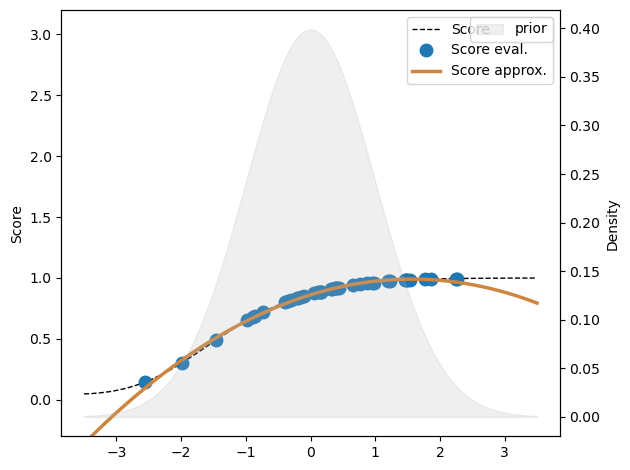

In [6]:
T_s = gmap.T(sample)
T_approx = exp_approximation(Ts=T_s, scores=score_sample, weights=weights)

T_xs = gmap.T(xs[:, np.newaxis])
score_approx = (T_xs * T_approx).sum(-1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.set_ylabel("Density")
ax1.set_ylabel("Score")

ax2.fill_between(xs, prior_norm.pdf(xs), color="0.7", alpha=0.2, label="prior")
ax1.plot(
    xs, score(xs[:, np.newaxis]), "--", linewidth=1.0, color="black", label="Score"
)

ax1.plot(sample, score_sample, "o", markersize=9.0, label="Score eval.")
ax1.set_ylim(-0.3, 3.2)

score_sample_approx = (T_s * T_approx).sum(-1)

delta = np.sum(weights * (score_sample - score_sample_approx))

ax1.plot(xs, delta + score_approx, color="peru", linewidth=2.5, label="Score approx.")
fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

The weighing process is used to compute the best L2 approximation of the score of a given form (here for gaussians, quadratic forms)

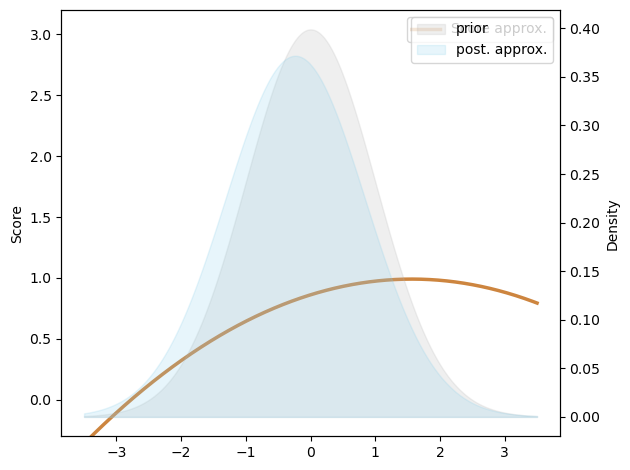

In [7]:
delta = np.sum(weights * (score_sample - (T_s * T_approx).sum(-1)))

T_prior = gmap.param_to_T(prior_param)
T_updt_dir = -(temp**-1) * T_approx
T_new = T_prior + (1 - dampen) * T_updt_dir

post_param = gmap.T_to_param(T_new)

post = gmap(post_param)
post_norm = norm(loc=post.means[0], scale=np.sqrt(post.cov[0, 0]))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.set_ylabel("Density")
ax1.set_ylabel("Score")

ax2.fill_between(xs, prior_norm.pdf(xs), color="0.7", alpha=0.2, label="prior")

ax1.set_ylim(-0.3, 3.2)

fig.tight_layout()

ax1.plot(xs, delta + score_approx, color="peru", linewidth=2.5, label="Score approx.")
fig.tight_layout()

ax2.fill_between(
    xs, post_norm.pdf(xs), color="skyblue", alpha=0.2, label="post. approx."
)
ax2.set_ylabel("Density")

ax1.set_ylabel("Score")

fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

The approximated score is used to compute the posterior update.
This learning cycle is then repeated until either convergence is achieved or the maximal number of optimisation steps is achieved.

The algorithm is now showcased on a more complex function, two dimensional for plotting purposes.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from surpbayes.bayes import pacbayes_minimize
from surpbayes.proba import GaussianMap, TensorizedGaussianMap

# For plotting purposes
from math import pi

angles = np.linspace(0, 2.001 * pi, 1000)
circle = np.array([np.cos(angles), np.sin(angles)])


def half_cov(cov):
    vals, vects = np.linalg.eigh(cov)
    return (np.sqrt(vals) * vects) @ vects.T


def repr_gauss(mean, cov, rad=1.0):
    """Visual representation of a 2D Gaussian distribution through ellipsis
    (representing highest density region, e.g. smallest volume region of a
    given probability (depending on rad))"""
    loc_circle = circle.copy()
    return mean + rad * (half_cov(cov) @ loc_circle).T


arr_1 = np.array([0.0, 1.0])
arr_2 = np.array([1, -1])
_shift = np.array([0.0, 0.5])


def score(x):
    z = x - _shift
    return 4 * np.arctan(0.5 * ((z @ arr_1 - 1.0) ** 2 + 100.0 * (z @ arr_2) ** 2))

Starting Bayesian calibration (Score Approximation routine, Gaussian variant)
Score at step 10/141: 4.108422889309838 (KL: 1.6552612428171563, score:3.9428967650281224)
Score at step 20/141: 1.0375333444385957 (KL: 4.663285938568199, score:0.5712047505817758)
End score:  0.7567283868716584 (KL: 6.515038445871559, score:0.1052245422845025)
Time elapsed: 1.6183512210845947


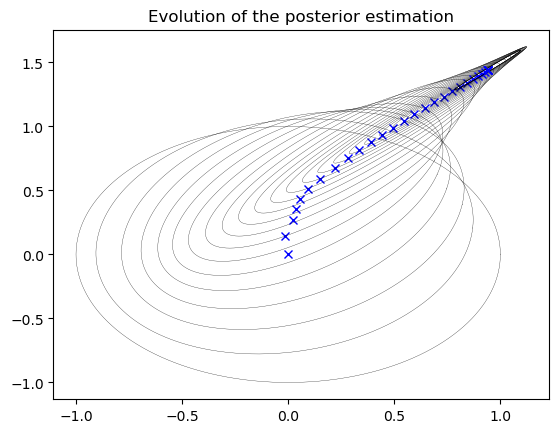

In [9]:
from surpbayes.proba import FactCovGaussianMap, FixedCovGaussianMap
from time import time

cov = np.array([[0.5, 0.4], [0.4, 0.5]])

# facgm = FactCovGaussianMap(2, cov=cov)
# ficgm = FixedCovGaussianMap(2, cov=cov)

gmap = GaussianMap(2)

tic = time()
opt_res_new = pacbayes_minimize(
    score,
    gmap,
    temperature=0.1,  
    optimizer="score_approx",
    per_step=96,
    parallel=False,
    vectorized=True,
    print_rec=10,
    chain_length=141,
    n_estim_weights=2 * 10**4,
    kl_max=0.04,
    m_max=20,
    xtol=10**-7,
    kltol=10**-7,
    silent=False,
    dampen=0.1,
)
tac = time()
print("Time elapsed:", tac - tic)

for i, param in enumerate(opt_res_new.hist_param[:]):
    if i % 1 == 0:
        proba = gmap(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
        plt.plot(proba.means[0], proba.means[1], "x", color = "blue")

plt.title("Evolution of the posterior estimation")
plt.show()

We plot the evolutions of the posterior in conjonction with the score heatmap

([], [])

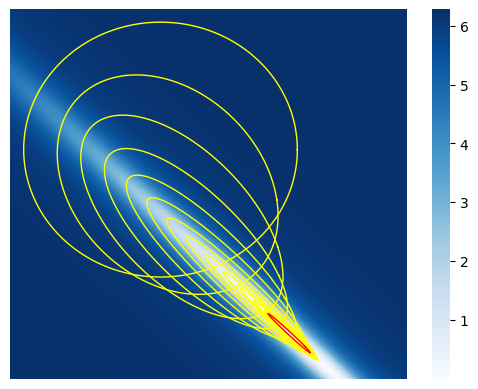

In [19]:
import seaborn as sns

x_min = -1.1
x_max = 1.8
n_x = 601

y_min = -1.1
y_max = 1.8
n_y = 601

x_axis_labels = np.linspace(
    x_min, x_max, n_x
)  # Avoid renormalisation issue at the angles
y_axis_labels = np.linspace(y_min, y_max, n_y)


def shift(xs, ys):
    return n_x * (xs - x_min) / (x_max - x_min), n_y * (ys - y_min) / (y_max - y_min)


values = np.array(np.meshgrid(y_axis_labels, x_axis_labels)).T

z = score(values)
alpha = np.linspace(0, 8, 100)

sns.heatmap(
    z.T,
    xticklabels=y_axis_labels,
    yticklabels=x_axis_labels,
    cmap=sns.color_palette("Blues", as_cmap=True),
)
# sns.heatmap(z)
for i, param in enumerate(opt_res_new.hist_param):
    if i % 2 == 0:
        proba = gmap(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        #         proba_repr  = repr_gauss(np.array([1.38,-1.1]), 0.01 * np.eye(2))

        xs, ys = shift(proba_repr[:, 0], proba_repr[:, 1])
        sns.lineplot(x=xs, y=ys, sort=False, color="yellow", linewidth=1.0)


proba = gmap(opt_res_new.opti_param)
proba_repr = repr_gauss(proba.means, proba.cov)

xs, ys = shift(proba_repr[:, 0], proba_repr[:, 1])
sns.lineplot(x=xs, y=ys, sort=False, color="red", linewidth=1.0)

plt.xticks([])
plt.yticks([])
# Note that the plot is turned compared to the previous version, due to seaborn's behavior for heatmap...


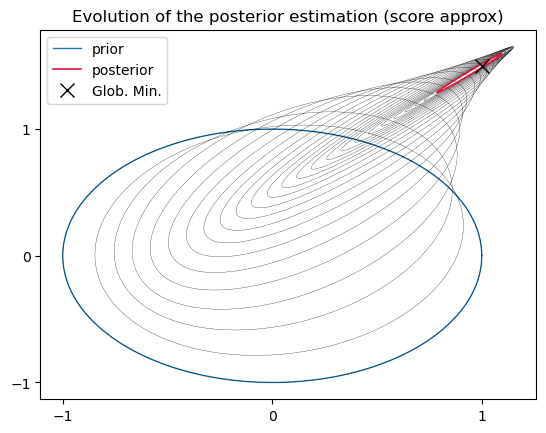

In [22]:
proba = gmap(opt_res_new.hist_param[0])
proba_repr = repr_gauss(proba.means, proba.cov)
plt.plot(proba_repr[:, 0], proba_repr[:, 1], linewidth=1.0, label="prior")

for i, param in enumerate(opt_res_new.hist_param[:-5]):
    if i % 1 == 0:
        proba = gmap(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
#         plt.plot(proba.means[0], proba.means[1], "x")

proba = gmap(opt_res_new.opti_param)
proba_repr = repr_gauss(proba.means, proba.cov)
plt.plot(
    proba_repr[:, 0],
    proba_repr[:, 1],
    linewidth=1.2,
    color="crimson",
    label="posterior",
)
global_minima = 1.0 + _shift
plt.plot(global_minima[0], global_minima[1], "x", c="k", markersize=10, label="Glob. Min.")

plt.title("Evolution of the posterior estimation (score approx)")
plt.legend()
plt.xticks([-1.0, 0.0, 1.0])
plt.yticks([-1.0, 0.0, 1.0])
plt.show()

The procedure can also be investigated for other family of distributions, for instance Gaussians with fixed variance

Starting Bayesian calibration (Score Approximation routine, Gaussian variant)


/Users/apicard/Documents/Suez/Git/neurips_surroogate_pac_bayes/surpbayes/src/surpbayes/optim/dichoto.py:141: UserWarning: The required precision in y could not be achieved
  warnings.warn("The required precision in y could not be achieved")


Score at step 10/61: 3.3378697864138642 (KL: 2.120200872724091, score:3.3166677776866234)
Score at step 20/61: 1.6555783155901982 (KL: 3.6755457036898798, score:1.6188228585532993)
Score at step 30/61: 0.94318036207899 (KL: 4.5885298322514565, score:0.8972950637564755)
Score at step 40/61: 0.631098560762191 (KL: 5.3300452538671115, score:0.5777981082235198)
Score at step 50/61: 0.5139504258509217 (KL: 5.825245876213548, score:0.4556979670887861)
Score at step 60/61: 0.5356012267119309 (KL: 6.163543974184272, score:0.4739657869700882)
End score:  0.5095638512546766 (KL: 6.229728345780978, score:0.4472665677968668)
9.974356889724731


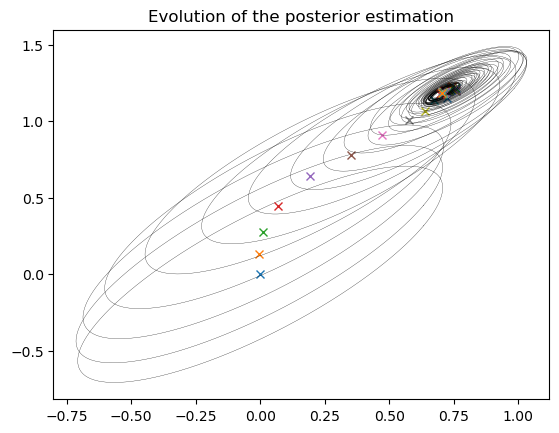

In [27]:
from surpbayes.proba import FactCovGaussianMap, FixedCovGaussianMap
from time import time

cov = np.array([[0.5, 0.4], [0.4, 0.5]])

ficgm = FixedCovGaussianMap(2, cov=cov) # Variance is fixed
facgm = FactCovGaussianMap(2, cov=cov) # Variance is fixed up to a multiplicative factor

proba_map = facgm
tic = time()
opt_res_new = pacbayes_minimize(
    score,
    proba_map,
    temperature=0.01,  
    optimizer="score_approx",
    per_step=160,
    parallel=False,
    vectorized=True,
    print_rec=10,
    chain_length=61,
    n_estim_weights=2*10**4,
    kl_max=0.05,
    m_max=20,
    xtol=10**-9,
    #     alpha_filter=0.99,
    silent=False,
    dampen=0.5,
)
tac = time()
print(tac - tic)
for i, param in enumerate(opt_res_new.hist_param):
    if i % 1 == 0:
        proba = proba_map(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
        plt.plot(proba.means[0], proba.means[1], "x")

plt.title("Evolution of the posterior estimation")
plt.show()

An interesting consideration is how much the posterior distribution gives weights to draws from previous distributions.

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='Step', ylabel='Mass'>)

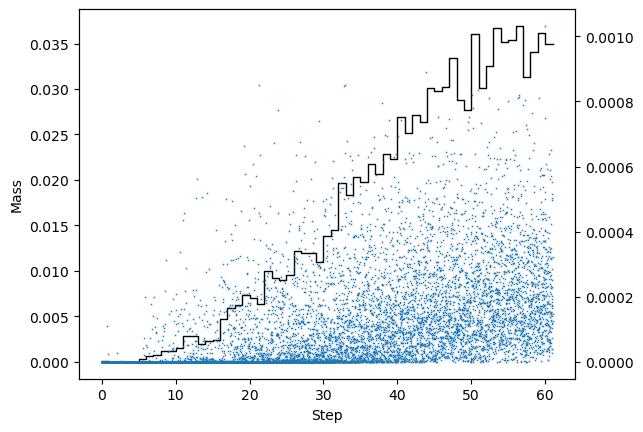

In [28]:
from surpbayes.bayes.plot.score_approx import plot_weights_per_gen

plot_weights_per_gen(opt_res_new, n_sample_estim_weight=10**6)

The evolution of the pushforward of the score by the posterior distribution can also be evaluated using the following plot

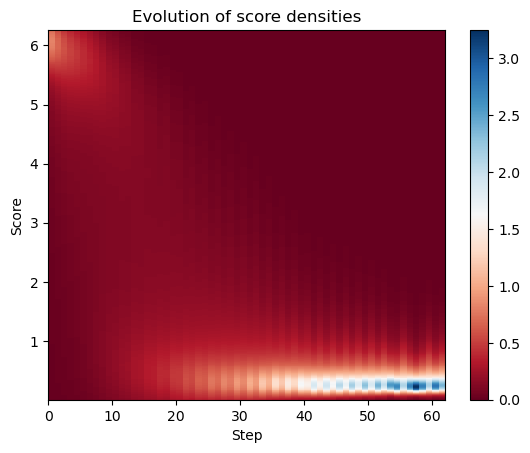

In [29]:
from surpbayes.bayes.plot.optim_result import plot_score_evol

plot = plot_score_evol(opt_res_new)
plot.show()

In [ ]:
from surpbayes.bayes.plot import plot_hist_bayes, plot_scores

plot = plot_scores(sample_val=opt_res_new.sample_val, marker="x", s=0.03)
plot.show()

In [31]:
from surpbayes.proba import FactCovGaussianMap, FixedCovGaussianMap

cov = np.array([[0.5, 0.4], [0.4, 0.5]])

facgm = FactCovGaussianMap(2, cov=cov)
ficgm = FixedCovGaussianMap(2, cov=cov)

opt_res_new = pacbayes_minimize(
    score,
    facgm,
    temperature=0.1,  
    optimizer="score_approx",
    per_step=160,
    parallel=False,
    vectorized=True,
    print_rec=10,
    chain_length=41,
    n_estim_weights=2*10**4,
    kl_max=10**-2,
    kltol=0.0,
    m_max=20,
    xtol=10**-6,
    silent=False,
    dampen=0.1,
)

Starting Bayesian calibration (Score Approximation routine, Gaussian variant)
Score at step 10/41: 4.7478950927169725 (KL: 0.6821715878007133, score:4.679677933936901)
Score at step 20/41: 3.634766668587469 (KL: 1.9229298250475946, score:3.4424736860827094)
Score at step 30/41: 2.5940777494348137 (KL: 2.945419199386054, score:2.2995358294962083)
Score at step 40/41: 2.1665112678822203 (KL: 3.4629154805704854, score:1.8202197198251717)
End score:  2.020537508437093 (KL: 3.5623787083419503, score:1.6642996376028978)


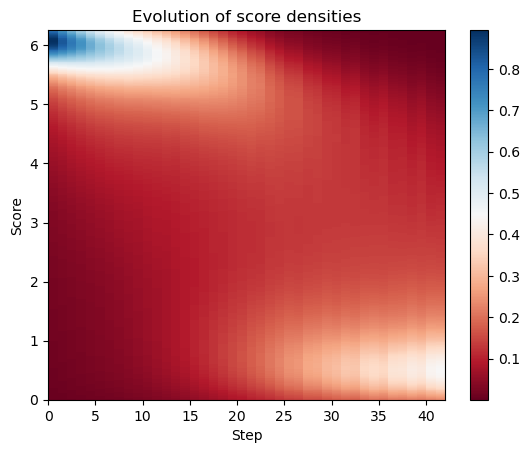

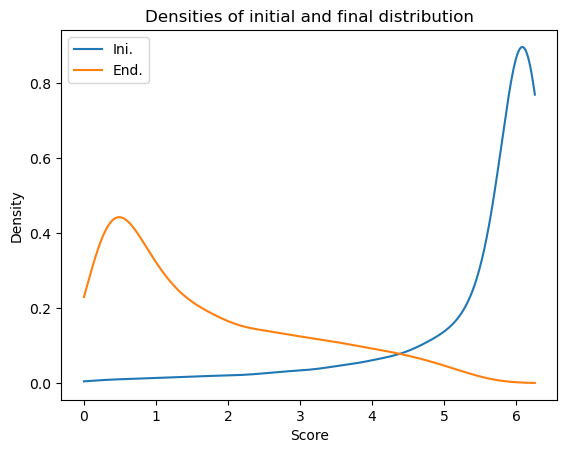

<Figure size 640x480 with 0 Axes>

In [32]:
from surpbayes.bayes.plot import plot_score_push_begin_end, plot_score_evol

plot = plot_score_evol(opt_res_new)
plot.show()
plot.clf()
plot = plot_score_push_begin_end(opt_res_new)
plot.show()
plot.clf()

We need to define the space of probability distributions on which we wish to optimize. Here we consider a score defined on a two dimensional space, and therefore use gaussian distributions on $\mathbb{R}^2$. The prior will be the standard distribution

## Gradient based algorithm

To use the gradient based routine, the parameter 'pac_bayes_solver' must be either "corr_weights" or "knn". It is advised to use 'corr_weights'.
It is normal behavior that the optimisation procedure raises some ProbaBadGrad warnings. These indicate that a problematic gradient estimation was rejected as it damaged significantly the score. No need to worry about those.

In [ ]:
gauss_map = GaussianMap(2)

# We define the prior as the reference gaussian distribution, i.e. N(0,Id)
prior_param = gauss_map.ref_param

# To minimize PAC-Bayes bound, we use the pacbayes_minimize function.
opt_res_grad = pacbayes_minimize(
    score,
    gauss_map,
    prior_param=prior_param,
    temperature=0.1,  
    per_step=160,
    optimizer="corr_weights",
    gen_decay=np.log(1.2),
    k=160 * 20,
    parallel=False,
    vectorized=True,
    print_rec=50,
    chain_length=501,
    refuse_conf=0.9,
    momentum=0.9,
    eta=0.05,
    silent=False,
)

# It is normal behavior that the optimisation procedure raises some ProbaBadGrad warnings.
# These indicate that a problematic gradient estimation was rejected as it damaged significantly
# the score. No need to worry about those.

# We can access the parameter describing the posterior through the opti_param attribute
post_param = opt_res_grad.opti_param

In [ ]:
proba = gmap(opt_res_grad.hist_param[0])
proba_repr = repr_gauss(proba.means, proba.cov)
plt.plot(proba_repr[:, 0], proba_repr[:, 1], linewidth=1.0, label="prior")

for i, param in enumerate(opt_res_grad.hist_param[:]):
    if i % 3 == 0:
        proba = gmap(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
#         plt.plot(proba.means[0], proba.means[1], "x")

proba = gmap(opt_res_grad.opti_param)
proba_repr = repr_gauss(proba.means, proba.cov)
plt.plot(
    proba_repr[:, 0],
    proba_repr[:, 1],
    linewidth=1.2,
    color="crimson",
    label="posterior",
)
plt.plot([1], [1], "x", c="0.0", markersize=10, label="Glob. Min.")

plt.title("Evolution of the posterior estimation (corr weights)")
plt.legend()
plt.xticks([-1.0, 0.0, 1.0])
plt.yticks([-1.0, 0.0, 1.0])
plt.savefig("corr_weights_training.png")
plt.show()


# for i, param in enumerate(opt_res_grad.hist_param[:-450]):
#     if i % 2 == 0:
#         proba = gauss_map(param)
#         proba_repr = repr_gauss(proba.means, proba.cov)
#         plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)

In [ ]:
# The optimisation start by modification of the covariance

for i, param in enumerate(opt_res_grad.hist_param[:25:2]):
    if i % 1 == 0:
        proba = gauss_map(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)

In [ ]:
# The distribution then shifts towards the correct mean value
for i, param in enumerate(opt_res_grad.hist_param[25:500:30]):
    if i % 1 == 0:
        proba = gauss_map(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)

In [ ]:
# The evolution of the PAC-Bayes objective can also be tracked:
plt.plot(opt_res_grad.hist_score)
plt.yscale("log")

In [ ]:
plot_score_push_begin_end(opt_res_grad)

## Score approximation

Score approximation is now the default way to optimise Catoni's bound for Gaussian, BlockDiagonalGaussian and ExponentialFamily distribution map. These yield much more stable result, but have more processing time between steps. The number of calls to the model is greatly reduced, and the results are more accurate, especially when the temperature is low.

In [ ]:
from surpbayes.proba import GaussianMap

gauss_map = GaussianMap(2)
opt_res_sa = pacbayes_minimize(
    score,
    gauss_map,
    # prior_param=prior_param,
    temperature=0.05,  
    optimizer="score_approx",
    per_step=160,
    parallel=False,
    vectorized=True,
    print_rec=1,
    chain_length=51,
    n_estim_weights=10**4,
    kl_max=0.1,
    m_max=20,
    xtol=10**-6,
    alpha_filter=0.9,
    silent=False,
)

In [ ]:
proba = gauss_map(opt_res_sa.opti_param)
proba_repr = repr_gauss(proba.means, proba.cov)
plt.plot(
    proba_repr[:, 0],
    proba_repr[:, 1],
    color="blue",
    linewidth=0.2,
    label="Approx. Score",
)

proba = gauss_map(opt_res_grad.opti_param)
proba_repr = repr_gauss(proba.means, proba.cov)
plt.plot(
    proba_repr[:, 0],
    proba_repr[:, 1],
    color="black",
    linewidth=0.2,
    label="Gradient Descent",
)
plt.legend()
plt.title("Result of optimisation routines")

The differences are significative. Both distributions exhibit high correlations. The score approximation routine migrated towards the minimum value $(1,1)$, while the gradient descent algorithm ended its migtration too early on.

We plot the successive distributions to exhibiti the improved stability of the training algorithm.

In [ ]:
for i, param in enumerate(opt_res_sa.hist_param):
    proba = gauss_map(param)
    proba_repr = repr_gauss(proba.means, proba.cov)
    plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
plt.title("Evolution of the posterior estimation")
plt.show()

The score now decreases in a much more regular fashion.

In [ ]:
plt.plot(opt_res_sa.hist_score)

### Checks for other distribution maps

In [ ]:
from surpbayes.proba import FactCovGaussianMap, FixedCovGaussianMap

cov = np.array([[1, 0.5], [0.5, 1]])

facgm = FactCovGaussianMap(2, cov=cov)
ficgm = FixedCovGaussianMap(2, cov=cov)

opt_res = pacbayes_minimize(
    score,
    facgm,
    temperature=0.001,  
    optimizer="score_approx",
    per_step=320,
    parallel=False,
    vectorized=True,
    print_rec=10,
    chain_length=51,
    n_estim_weights=10**4,
    kl_max=0.1,
    m_max=20,
    xtol=10**-6,
    alpha_filter=0.9,
    silent=False,
)

The setting above was a special case, where the true score was quadratic. As the score_approx algorithm for gaussians relies on quadratic approximation, this heavily favors this approach. We investigate a case where the approximations looked for (quadratic with diagonal matrix) does not fit the true score (quadratic).

In [ ]:
for i, param in enumerate(opt_res.hist_param[:5]):
    if i % 1 == 0:
        proba = facgm(param)
        proba_repr = repr_gauss(proba.means, proba.cov)
        plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
        plt.plot(proba.means[0], proba.means[1], "x")

plt.title("Evolution of the posterior estimation")
plt.show()

In [ ]:
# Set corr between -1 and 1. The higher the absolute value of corr, the harder the problem is.
corr = 0.7


def make_mat(vars, corr=0.0):
    assert np.abs(corr) < 1.0
    anti_diag = np.sqrt(vars[0] * vars[1]) * corr
    return np.array([[vars[0], anti_diag], [anti_diag, vars[1]]])


center = np.array([-1.0, 1.0])
mat = make_mat([4.0, 1.0], corr)


def score(xs):
    return (((xs - center) @ mat) * (xs - center)).sum(-1)


from surpbayes.proba import BlockDiagGaussMap

bgmap = BlockDiagGaussMap([[1], [0]])

opt_res = pacbayes_minimize(
    score,
    bgmap,
    temperature=0.2,
    per_step=320,
    kl_max=0.5,
    chain_length=30,
    dampen=0.0,
    alpha_filter=0.95,
    n_estim_weights=3 * 10**5,
    vectorized=True,
)

### Amount of reuse of the previous evaluations
The whole point of the score_approx technique is to make most use of all previous evaluations of the score. We can track the impact these previous evaluations have by checking the weight given to each sample at the posterior distribution.

In [ ]:
from surpbayes.bayes.plot import plot_weight_per_gen

plot_weight_per_gen(opt_res)

In [ ]:
from surpbayes.bayes.score_approx.weighing.monte_carlo import get_weights_mc_gauss

weights = get_weights_mc_gauss(
    bgmap(opt_res.opti_param), opt_res.sample_val.sample(), n_sample_estim=10**6
)
plt.plot(weights)
plt.show()
weights_per_gen = weights.reshape((30, 320)).sum(1)
plt.plot(weights_per_gen, label="Tot weight per generation")
plt.legend()
plt.show()

While the first 5 generations have smaller impact, all generations after generation 8 have non negligible weight.

In [ ]:
[bgmap.kl(par1, par0) for par1, par0 in zip(opt_res.hist_param[1:], opt_res.hist_param)]

In [ ]:
# The distribution then shifts towards the correct mean value
for i, param in enumerate(opt_res.hist_param):
    proba = bgmap(param)
    proba_repr = repr_gauss(proba.means, proba.cov)
    plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
plt.show()
plt.clf()
plt.plot(opt_res.hist_score)

Under the hood, pacbayes_minimize can redirect to two routines (pac_bayes_solver argument): either "corr_weights" or "KNN". The name refers to the method used in order to make most use of the evaluations to the score function.

The 'pacbayes_minimize' function was designed for situations where evaluating the 'score' is rather expensive. It is still, however, an accelarated gradient descent algorithm. The change is that the gradient's expression involves an expectation with respect to the current distribution. The naïve approach consisting in sampling iid samples from the current distribution to obtain an unbiased estimation of the expectation is improved upon by recycling previous samples. These are generated from distributions similar to the current one, if small optimization steps are done ('eta' parameter is small).

As it is not possible to use these samples directly, two procedures are proposed. "corr_weights" consists in giving each sample a weight to adjust for the difference of probability for it being drawn between the current and previous distributions. "KNN" consists in constructing a surrogate score using a K-Nearest neighbor algorithm, then using this surrogate on a large number of samples to compute the derivative.

The number of samples used all in all when evaluating the derivative is controlled by the argument 'k'. By default it is None, amounting to all samples being used.

For "corr_weights", it is possible and advisable to set the 'gen_decay' parameter higher than 0 (default value). The 'gen_decay' parameter gives a decreasing weights to older generations when computing the derivative. While generations just before tend to be close to the current one, older ones would no longer be representative, and could have a negative impact when computing the derivative. The higher 'gen_decay', the lower will be the influence of older generation (exponentially decreasing weights of $\exp(-t \times gen\_decay)$ are used).

For "KNN", the number of neighbors used by the K-nearest neighbors algorithm is NOT controlled by the argument 'k', but by "n_neighbors". As stated above, "k" controls the number of samples used. By default, "n_neighbors" is 5.


The 'corr_weights' method has the edge in most cases. For instance, 'KNN' by design does not like situations where the Hessian near the minima has eigenvalues of different magnitudes, which is the case for the Rosenbrock function tested here. This could be improved upon by learning the distance used in 'KNN', or by training different surrogates.

In [ ]:
# For comparison, pacbayes_minimize with KNN method

opt_res = pacbayes_minimize(
    score,
    gauss_map,
    prior_param=prior_param,
    temperature=0.1,
    per_step=1600,
    optimizer="knn",
    k=None,
    parallel=False,
    print_rec=20,
    chain_length=600,
    vectorized=True,
    momentum=0.99,
    eta=0.1,
    silent=True,
)

end_proba = gauss_map(opt_res.opti_param)

print(
    f"Mean score of estimated posterior: {end_proba.integrate(score, n_sample = 1000)}"
)

# The evolution of the PAC-Bayes objective can also be tracked:
plt.plot(opt_res.hist_score)

## Uniform priors - Gaussian computations

The proba module offers a class of distributions on the hypercube benefitting from Gaussian like interpretation when the distribution are sufficiently concentrated and exact computations for KL.

In [10]:
from surpbayes.proba.gauss import GaussHypercubeMap

dim = 2

# Toy score function
def score(x):
    return np.arctan(
        0.2 * (x @ np.array([1.0, 0.0], dtype=np.float64) - 0.6) ** 2
        + 20 * (x @ np.array([1.0, -2.0], dtype=np.float64)) ** 2
    )


pmap = GaussHypercubeMap(2)

In [11]:
opt_res = pacbayes_minimize(
    score,
    pmap,
    temperature=0.01,  
    per_step=80,
    dampen=0.1,
    kl_max=0.2,
    parallel=False,
    vectorized=True,
    print_rec=10,
    chain_length=51,
    silent=False,
)

Starting Bayesian calibration (Score Approximation routine, Pre Exponential Family variant)
Score at step 10/51: 0.11586849787857662 (KL: 5.026647378668448, score:0.06560202409189213)
Score at step 20/51: 0.0544087892867419 (KL: 4.301693048472228, score:0.011391858802019617)
Score at step 30/51: 0.05156127715882219 (KL: 4.309449023251119, score:0.008466786926310999)
Score at step 40/51: 0.05190279239473286 (KL: 4.39919862752739, score:0.007910806119458958)
Score at step 50/51: 0.05247347423744009 (KL: 4.426628735127369, score:0.008207186886166404)
End score:  0.052420692197968494 (KL: 4.400368771597547, score:0.00841700448199302)


The posterior can adapt to scores with strong identifiability issues such as Rosenbrock, since the probabilities can exhibit strong correlation structure

([], [])

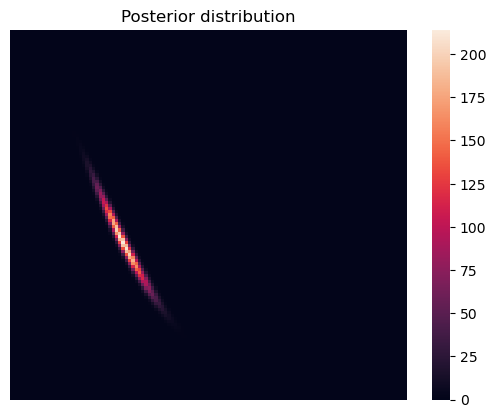

In [12]:
import seaborn as sns

proba = pmap(opt_res.opti_param)
# The log density of the function can be accessed through log_dens
x_axis_labels = np.linspace(10**-4, 1 - 10**-4, 121)
y_axis_labels = np.linspace(10**-4, 1 - 10**-4, 121)

values = np.array(np.meshgrid(y_axis_labels, x_axis_labels)).T
z = proba.dens(values)

sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Posterior distribution")
plt.xticks([])
plt.yticks([])

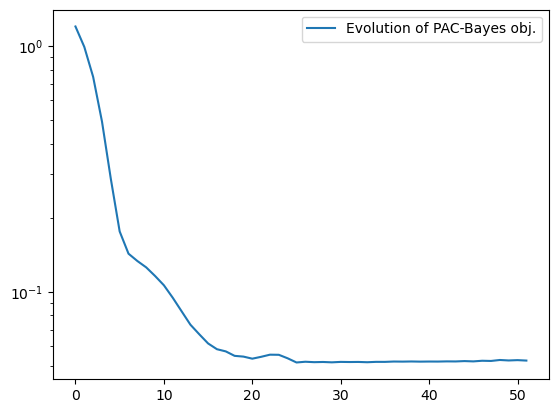

In [13]:
plt.plot(opt_res.hist_score, label="Evolution of PAC-Bayes obj.")
plt.yscale("log")
plt.legend()
plt.show()

In [14]:
## Tests for problems of larger dimensions

d = 80
k = 5

blocks = [list(range(i * k, min(d, (i + 1) * k))) for i in range(int(np.ceil(d / k)))]

mat = (np.random.uniform(0.5, 2, d)) * np.random.normal(0, 1, (4 * d, d))
mat = mat.T @ mat / (4 * d)

print(np.linalg.eigvalsh(mat))

center = np.random.normal(0, 1, d)

[0.15050738 0.16930336 0.17215579 0.19862439 0.20857411 0.22337668
 0.25124782 0.26577534 0.27655638 0.28397492 0.31315143 0.33546463
 0.35201385 0.36454891 0.39796759 0.40639623 0.42540618 0.43569007
 0.46525946 0.47638048 0.50018647 0.5489928  0.56072941 0.61180019
 0.64262393 0.66084838 0.73142489 0.75312436 0.77058688 0.81227809
 0.82725828 0.93342137 0.96021518 1.03024763 1.08525882 1.10084119
 1.18635959 1.21332078 1.24998062 1.3840096  1.42612184 1.50466508
 1.51140703 1.56588425 1.6225791  1.63478445 1.82155356 1.89452683
 1.93362497 2.05665944 2.13007053 2.19656636 2.239917   2.25809789
 2.37300232 2.47273514 2.52845408 2.61327592 2.66658229 2.72727154
 2.85209728 2.92708606 3.11227967 3.14494602 3.22863149 3.31298455
 3.39244621 3.44643715 3.64332431 3.71264937 3.84043453 3.95677989
 4.19376033 4.26857993 4.4737285  4.56152225 4.88558125 5.05000987
 5.09610056 5.85024453]


In [15]:
def score(xs):
    deltas = np.arctan(xs - center)
    return (deltas * (deltas @ mat)).sum(-1)


bgmap = BlockDiagGaussMap(blocks)

In [16]:
opt_res = pacbayes_minimize(
    score,
    bgmap,
    per_step=800,
    kl_max=3.0,
    temperature=0.1,
    chain_length=20,
    vectorized=True,
)

Starting Bayesian calibration (Score Approximation routine, Gaussian variant)


/Users/apicard/Documents/Suez/Git/neurips_surroogate_pac_bayes/surpbayes/src/surpbayes/optim/dichoto.py:141: UserWarning: The required precision in y could not be achieved
  warnings.warn("The required precision in y could not be achieved")


Score at step 1/20: 78.74325709998529 (KL: 0.0, score:78.74325709998529)
Score at step 2/20: 64.74613353120519 (KL: 2.9999999999999996, score:64.44613353120519)
Score at step 3/20: 53.876609940361824 (KL: 8.94271275807914, score:52.98233866455391)
Score at step 4/20: 46.890971190183045 (KL: 15.478930240623448, score:45.3430781661207)
Score at step 5/20: 38.522675766249044 (KL: 23.351479043066284, score:36.187527861942414)
Score at step 6/20: 33.168405603279936 (KL: 32.11989500772424, score:29.956416102507514)
Score at step 7/20: 28.616406415295305 (KL: 40.86601076525412, score:24.529805338769894)
Score at step 8/20: 25.530269902035144 (KL: 50.561499556488165, score:20.474119946386327)
Score at step 9/20: 22.645297217638618 (KL: 59.15207858582991, score:16.730089359055626)
Score at step 10/20: 20.028281767573265 (KL: 68.17483163738206, score:13.210798603835059)
Score at step 11/20: 18.7491965206612 (KL: 77.9877971367325, score:10.95041680698795)
Score at step 12/20: 17.861926718381234 (

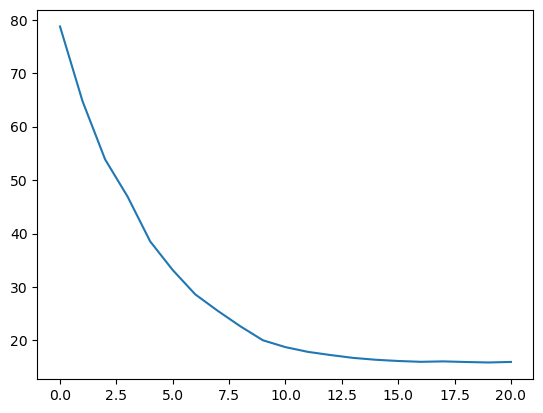

In [18]:
plt.plot(opt_res.hist_score)

# Checking stability

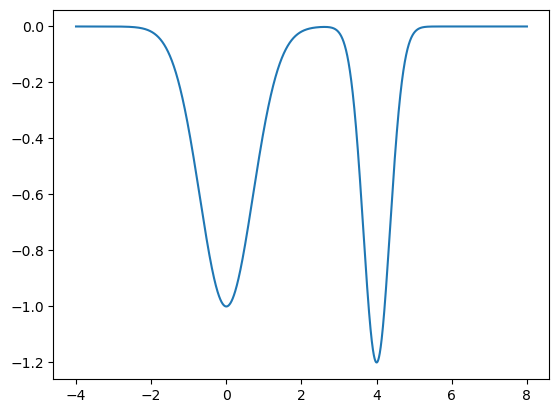

In [19]:
def score(x):
    return -(
        1.2 * np.exp(-4 * (x @ [1] - 4) ** 2) + 1.0 * np.exp(-1.0 * (x @ [1]) ** 2)
    )


xs = np.linspace(-4, 8, 4000).reshape((4000, 1))

plt.plot(xs, score(xs))

In [ ]:
from surpbayes.accu_xy import AccuSampleVal

xs = np.linspace(3.5, 4.5, 1000).reshape((1000, 1))
accu = AccuSampleVal((1,), 1000)
accu.add(xs, score(xs))

In [ ]:
2 * (1 - norm.cdf(4))

In [ ]:
from scipy.stats import norm

gmap = GaussianMap(1)

tic = time()
opt_res_stable = pacbayes_minimize(
    score,
    gmap,
    #     facgm,
    #     prev_eval=accu, # Check if this improves matter or not
    temperature=0.002,  
    pac_bayes_solver="score_approx",
    prior_param=np.array([[0.0], [2.0]]),
    post_param=np.array([[4.0], [1.0]]),
    per_step=100,
    parallel=True,
    vectorized=False,
    print_rec=10,
    chain_length=101,
    n_estim_weights=10**6,
    kl_max=0.1,
    m_max=20,
    xtol=10**-8,
    kltol=10**-8,
    alpha_filter=1.0,
    silent=False,
    dampen=0.01,
)
tac = time()
print("Time elapsed:", tac - tic)

xs = np.linspace(-4, 6, 1000)

for i, param in enumerate(opt_res_stable.hist_param[:]):
    if i % 2 == 0:
        proba = gmap(param)
        plt.plot(
            xs,
            norm(proba.means[0], np.sqrt(proba.cov[0])).pdf(xs),
            color="black",
            linewidth=0.4,
        )
#         proba_repr = repr_gauss(proba.means, proba.cov)
#         plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
#         plt.plot(proba.means[0], proba.means[1], "x")

plt.title("Evolution of the posterior estimation")
plt.show()

In [ ]:
opt_res_stable.opti_param

In [ ]:
for i, param in enumerate(opt_res_stable.hist_param[10:30]):
    if i % 1 == 0:
        proba = gmap(param)
        plt.plot(
            xs,
            norm(proba.means[0], np.sqrt(proba.cov[0])).pdf(xs),
            color="black",
            linewidth=0.4,
        )
#         proba_repr = repr_gauss(proba.means, proba.cov)
#         plt.plot(proba_repr[:, 0], proba_repr[:, 1], color="black", linewidth=0.2)
#         plt.plot(proba.means[0], proba.means[1], "x")

plt.title("Evolution of the posterior estimation")
plt.show()